<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/Image_Adversaries_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents of this notebook come from: https://adversarial-ml-tutorial.org/introduction/.

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
!wget https://adversarial-ml-tutorial.org/introduction/pig.jpg

In [0]:
import matplotlib.pyplot as plt

def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

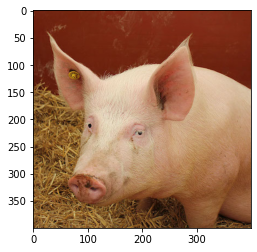

In [0]:
sample_image = show_image("pig.jpg")

In [0]:
# Load ResNet50
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [0]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import cv2

def preprocess_image(image_pixels):
    image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

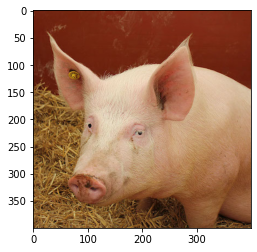

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02395406', 'hog', 0.99968374), ('n02396427', 'wild_boar', 0.000315947), ('n03935335', 'piggy_bank', 9.827297e-08)]


In [0]:
# Preprocess the image
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)

# Run inference
preds = resnet50.predict(preprocessed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

In [0]:
# Class index
preds.argmax()

341

In [0]:
!wget https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

In [0]:
# Parse the label
import json

with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[preds.argmax()])

hog


In [0]:
# Loss has to be very low here
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([341]),
    tf.convert_to_tensor(preds)
)
print(loss.numpy())

0.00041738382


In [0]:
# The probability we got when we ran the inference
np.exp(-loss.numpy())

0.9995827

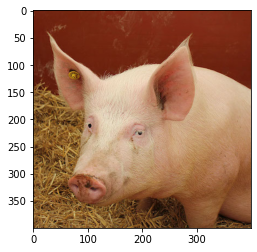

In [0]:
def preprocess_image_without(image_pixels):
    # image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Load and preprocess image but a but without any `preprocess_input`
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image_without(sample_image)

# Initialize the perturbation quantity
image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

In [0]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [0]:
# Let's create an adversarial example
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [0]:
# Generate Adversaries
scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()

for t in range(50):
    plt.show()
    with tf.GradientTape() as tape:
        tape.watch(delta)
        inp = preprocess_input(image_tensor + delta)
        predictions = resnet50(inp, training=False)
        loss = - scc_loss(
                tf.convert_to_tensor([341]),
                predictions
            )
        if t % 5 == 0:
            print(t, loss.numpy())
            # plt.imshow(50*delta.numpy().squeeze()+0.5)
        
    # Get the gradients
    gradients = tape.gradient(loss, delta)
    
    # Update the weights
    optimizer.apply_gradients([(gradients, delta)])

    # Clip so that the delta values are within [0,1]
    delta.assign_add(clip_eps(delta))

0 -0.00041249825
5 -0.0010656399
10 -0.005332769
15 -0.063206084
20 -0.7694784
25 -3.4453597
30 -7.3862996
35 -13.150285
40 -16.118187
45 -16.118193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


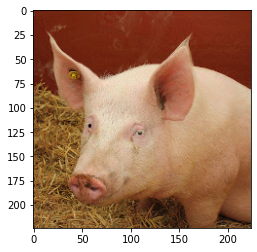

In [0]:
# See if the image changes
plt.imshow((image_tensor + delta).numpy().squeeze()/255)
plt.show()

In [0]:
# Generate prediction
perturbed_image = preprocess_input(image_tensor + delta)
preds = resnet50.predict(perturbed_image)
print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

Predicted: [('n01883070', 'wombat', 0.9999783), ('n02909870', 'bucket', 1.3295623e-05), ('n02454379', 'armadillo', 1.9243712e-06)]


In [0]:
def generate_adversaries(image_tensor, delta):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    for t in range(50):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = resnet50(inp, training=False)
            loss = - scc_loss(
                    tf.convert_to_tensor([341]),
                    predictions
                )
            if t % 5 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(image_path):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image_without(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = resnet50.predict(preprocess_input(preprocessed_image))
    print('Predicted before adv.:', tf.keras.applications.resnet50.decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries(image_tensor, delta)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = resnet50.predict(perturbed_image)
    print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

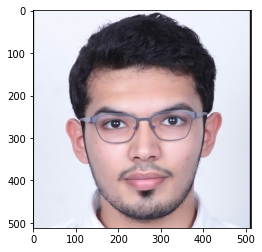

Predicted before adv.: [('n03630383', 'lab_coat', 0.32476106), ('n02883205', 'bow_tie', 0.24916495), ('n04591157', 'Windsor_tie', 0.18753329)]
0 -16.11811
5 -16.118116
10 -16.118132
15 -16.118143
20 -16.11815
25 -16.118158
30 -16.118162
35 -16.118166
40 -16.11817
45 -16.118172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


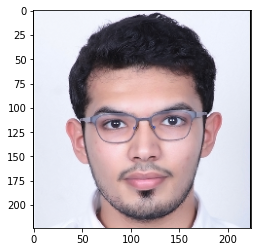

Predicted: [('n02883205', 'bow_tie', 0.42926234), ('n03630383', 'lab_coat', 0.30244228), ('n04591157', 'Windsor_tie', 0.18685246)]


In [0]:
perturb_image("abhishek.jpeg")

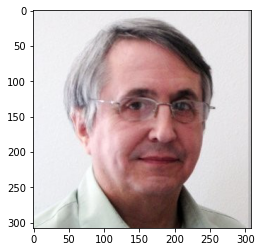

Predicted before adv.: [('n04350905', 'suit', 0.35708505), ('n03630383', 'lab_coat', 0.32163915), ('n04591157', 'Windsor_tie', 0.2767707)]
0 -16.118122
5 -16.11813
10 -16.118145
15 -16.118158
20 -16.118168
25 -16.118176
30 -16.11818
35 -16.118183
40 -16.118185
45 -16.118187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


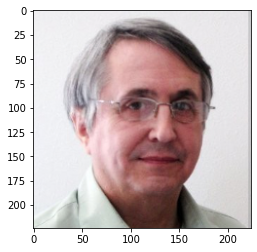

Predicted: [('n04591157', 'Windsor_tie', 0.47955543), ('n04350905', 'suit', 0.45154327), ('n03630383', 'lab_coat', 0.05686946)]


In [0]:
perturb_image("mcduffee.jpeg")

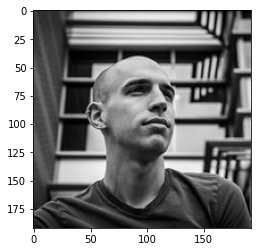

Predicted before adv.: [('n04005630', 'prison', 0.46007988), ('n04501370', 'turnstile', 0.28986117), ('n03595614', 'jersey', 0.057655428)]
0 -10.969547
5 -15.915204
10 -16.118181
15 -16.118187
20 -16.118189
25 -16.11819
30 -16.11819
35 -16.11819
40 -16.11819
45 -16.118193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


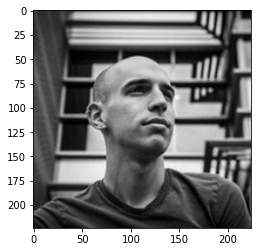

Predicted: [('n04501370', 'turnstile', 0.73284173), ('n04005630', 'prison', 0.26707217), ('n03255030', 'dumbbell', 7.306671e-05)]


In [0]:
perturb_image("adrian.jpeg")

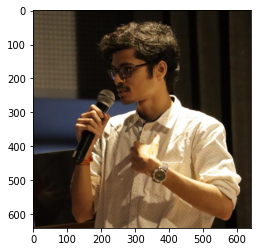

Predicted before adv.: [('n03759954', 'microphone', 0.93643415), ('n03494278', 'harmonica', 0.009305212), ('n03476991', 'hair_spray', 0.007406009)]
0 -15.8361845
5 -16.118176
10 -16.118181
15 -16.118183
20 -16.118185
25 -16.118187
30 -16.118187
35 -16.118187
40 -16.118187
45 -16.118189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


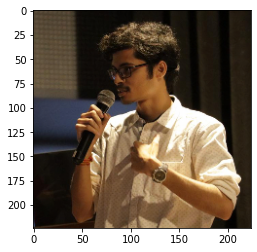

Predicted: [('n03759954', 'microphone', 0.9982591), ('n03494278', 'harmonica', 0.0012422426), ('n04296562', 'stage', 0.00037770855)]


In [0]:
perturb_image("avijit.jpeg")

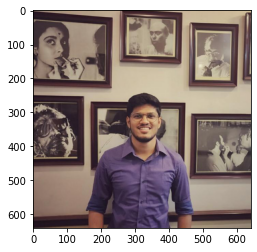

Predicted before adv.: [('n02883205', 'bow_tie', 0.11259429), ('n03141823', 'crutch', 0.080928504), ('n03179701', 'desk', 0.057526957)]
0 -11.010462
5 -16.118145
10 -16.11818
15 -16.118189
20 -16.118193
25 -16.118193
30 -16.118193
35 -16.118195
40 -16.118195
45 -16.118196


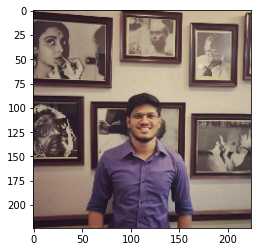

Predicted: [('n03814639', 'neck_brace', 0.99566084), ('n02883205', 'bow_tie', 0.0042970316), ('n04591157', 'Windsor_tie', 4.0156883e-05)]


In [0]:
perturb_image("ritwik.jpeg")

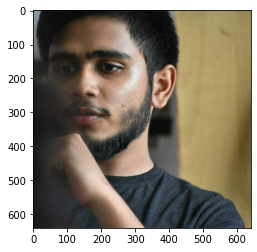

Predicted before adv.: [('n02791270', 'barbershop', 0.15106253), ('n03595614', 'jersey', 0.08922517), ('n04376876', 'syringe', 0.045663025)]
0 -11.136633
5 -16.118114
10 -16.11813
15 -16.118134
20 -16.118135
25 -16.118137
30 -16.118137
35 -16.118137
40 -16.118137
45 -16.118137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


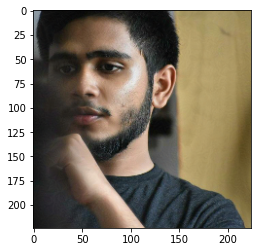

Predicted: [('n02791270', 'barbershop', 0.45213148), ('n04376876', 'syringe', 0.17672828), ('n04209239', 'shower_curtain', 0.047002688)]


In [0]:
perturb_image("aritra.jpeg")

In [0]:
def generate_adversaries_targeted(image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = resnet50(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(image_path, true, target):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image_without(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = resnet50.predict(preprocess_input(preprocessed_image))
    print('Predicted before adv.:', tf.keras.applications.resnet50.decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = resnet50.predict(perturbed_image)
    print('Predicted:', tf.keras.applications.resnet50.decode_predictions(preds, top=3)[0])

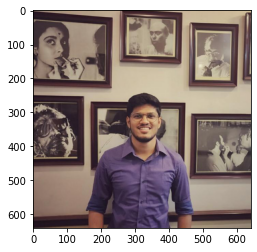

Predicted before adv.: [('n02883205', 'bow_tie', 0.11259429), ('n03141823', 'crutch', 0.080928504), ('n03179701', 'desk', 0.057526957)]
0 8.826496
20 3.4997158
40 0.5274625
60 -1.5777264
80 -3.2879686
100 -4.722042
120 -5.9527655
140 -7.0989666
160 -8.263369
180 -9.36035
200 -10.568922
220 -11.743231
240 -12.973064
260 -14.267328
280 -15.449568
300 -16.055637
320 -16.054358
340 -16.060879


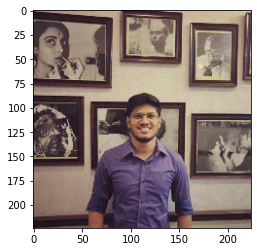

Predicted: [('n02395406', 'hog', 0.9470334), ('n02110341', 'dalmatian', 0.012297213), ('n02791270', 'barbershop', 0.0070770467)]


In [0]:
perturb_image("ritwik.jpeg", 457, 341)

In [0]:
for key, value in imagenet_classes.items():
    if imagenet_classes[key] == "bow_tie":
        print(key)

457
